In [1]:
import numpy as np
from scipy import *
from pylab import *
import os
import pickle
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

%matplotlib inline

In [2]:
folder_Pk = '/global/cscratch1/sd/jialiu/CAMELS/Pk/' ### original, unorganized Pk
home = '/global/homes/j/jialiu/cosmo_dep_feedback/'

###### the simulation we operate with
isim = 'IllustrisTNG'

In [3]:
### fixed parameters: 
Omega_b = 0.049
h = 0.6711
ns = 0.9624
w = -1
mnu = 0.0 #eV
Omega_k = 0.0

#### Omega_m sigma_8 A1 A2 A3 A4
lhc_params = np.loadtxt(home+'latin_hypercube_params_%s.txt'%(isim))
lhc_params = concatenate([lhc_params[:,:2], log10(lhc_params[:,2:])],axis=1)


In [4]:
######## get all the redshifts
_out=os.listdir('/global/cscratch1/sd/jialiu/CAMELS/Pk/%s/LH_0/'%(isim))
zarr_all=[]
for _iout in _out:
    if _iout[:4]=='Pk_m':
        zarr_all.append(float(_iout[7:-4]))
zarr_all=sorted(zarr_all)
print(zarr_all)

[0.0, 0.05, 0.1, 0.15, 0.21, 0.27, 0.33, 0.4, 0.47, 0.54, 0.61, 0.69, 0.77, 0.86, 0.95, 1.05, 1.15, 1.25, 1.36, 1.48, 1.6, 1.73, 1.86, 2.0, 2.15, 2.3, 2.46, 2.63, 2.81, 3.0, 3.5, 4.0, 5.0, 5.99, 127.0]


In [5]:
###################################################################
############ organize the files and save to the ideal format
###################################################################
k=np.load(home+'Pk/IllustrisTNG_k_m_z=0.00.npy')
zarr=[0.00, 1.05, 2.00, 0.05, 0.10, 0.15] #
for ifolder in [isim,  isim+'_DM']:
    for iz in zarr:
        ifn=home+'Pk/%s_Pk_m_z=%.2f.npy'%(ifolder, iz)
        if os.path.isfile(ifn):
            print(ifn, 'file already exist, continue')
        else:
            print (ifolder, iz)
            Pk_arr = array([np.loadtxt(folder_Pk+'%s/LH_%i/Pk_m_z=%.2f.txt'%(ifolder, i, iz)) for i in range(1000)])
            save(ifn, Pk_arr[:,:,1])
            if sum(Pk_arr[0,:,0]-k):
                print (ifolder, iz, 'k different')
                save(home+'Pk/%s_k_m_z=%.2f.npy'%(ifolder, iz), Pk_arr[0,:,0])

/global/homes/j/jialiu/cosmo_dep_feedback/Pk/IllustrisTNG_Pk_m_z=0.00.npy file already exist, continue
/global/homes/j/jialiu/cosmo_dep_feedback/Pk/IllustrisTNG_Pk_m_z=1.05.npy file already exist, continue
/global/homes/j/jialiu/cosmo_dep_feedback/Pk/IllustrisTNG_Pk_m_z=2.00.npy file already exist, continue
/global/homes/j/jialiu/cosmo_dep_feedback/Pk/IllustrisTNG_Pk_m_z=0.05.npy file already exist, continue
/global/homes/j/jialiu/cosmo_dep_feedback/Pk/IllustrisTNG_Pk_m_z=0.10.npy file already exist, continue
/global/homes/j/jialiu/cosmo_dep_feedback/Pk/IllustrisTNG_Pk_m_z=0.15.npy file already exist, continue
/global/homes/j/jialiu/cosmo_dep_feedback/Pk/IllustrisTNG_DM_Pk_m_z=0.00.npy file already exist, continue
/global/homes/j/jialiu/cosmo_dep_feedback/Pk/IllustrisTNG_DM_Pk_m_z=1.05.npy file already exist, continue
/global/homes/j/jialiu/cosmo_dep_feedback/Pk/IllustrisTNG_DM_Pk_m_z=2.00.npy file already exist, continue
/global/homes/j/jialiu/cosmo_dep_feedback/Pk/IllustrisTNG_DM_Pk_

In [6]:
## save GP: https://stackoverflow.com/questions/55386254/how-to-save-and-load-gaussian-process-for-production
## test passed

def buildGP (z, ifolder=isim, kmax=10,  noise_std =  0.05, Ntest=900, particles='m'):

    if particles=='m':
        ifn=home + "GP/GP_%s_z%.2f_kmax%i_noise%.3f_N%i.dump"%(ifolder, z, kmax, noise_std, Ntest)
    else: 
        ifn=home + "GP/GP_%s_%s_z%.2f_kmax%i_noise%.3f_N%i.dump"%(ifolder, particles, z, kmax, noise_std, Ntest)
    if os.path.isfile(ifn):
        print (ifn, 'already built')
        GP = pickle.load(open(ifn,"rb"))
        return GP
    else:
        print (ifn, 'being built')
        Pk_0 = np.load(home+'Pk/%s_Pk_%s_z=%.2f.npy'%(ifolder, particles, z))
        Pk_DM_0 = np.load(home+'Pk/%s_DM_Pk_m_z=%.2f.npy'%(ifolder, z))

        kidx=len(k[k<kmax])## cut at kmax
        knew = k[:kidx]
        r_Pk0=(Pk_0/Pk_DM_0)

        lhc_params = np.loadtxt(home+'latin_hypercube_params_%s.txt'%(ifolder))
        lhc_params = concatenate([lhc_params[:,:2], log10(lhc_params[:,2:])],axis=1)
        lhc_test=lhc_params[:Ntest]
        r_Pk = r_Pk0[:Ntest, :kidx]

        kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
        GP = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=noise_std**2)

        ###### takes long to compute, save to file
        GP.fit(lhc_test, r_Pk)
        with open(ifn , "wb") as f:
            pickle.dump(GP, f)  
        return GP

In [7]:
########## mass produce GP
for z in zarr:
    for Ntest in [900, 1000]:
        buildGP (z, ifolder=isim, kmax=10,  noise_std =  0.05, Ntest=Ntest)

/global/homes/j/jialiu/cosmo_dep_feedback/GP/GP_IllustrisTNG_z0.00_kmax10_noise0.050_N900.dump already built
/global/homes/j/jialiu/cosmo_dep_feedback/GP/GP_IllustrisTNG_z0.00_kmax10_noise0.050_N1000.dump already built
/global/homes/j/jialiu/cosmo_dep_feedback/GP/GP_IllustrisTNG_z1.05_kmax10_noise0.050_N900.dump already built
/global/homes/j/jialiu/cosmo_dep_feedback/GP/GP_IllustrisTNG_z1.05_kmax10_noise0.050_N1000.dump already built
/global/homes/j/jialiu/cosmo_dep_feedback/GP/GP_IllustrisTNG_z2.00_kmax10_noise0.050_N900.dump already built
/global/homes/j/jialiu/cosmo_dep_feedback/GP/GP_IllustrisTNG_z2.00_kmax10_noise0.050_N1000.dump already built
/global/homes/j/jialiu/cosmo_dep_feedback/GP/GP_IllustrisTNG_z0.05_kmax10_noise0.050_N900.dump already built
/global/homes/j/jialiu/cosmo_dep_feedback/GP/GP_IllustrisTNG_z0.05_kmax10_noise0.050_N1000.dump already built
/global/homes/j/jialiu/cosmo_dep_feedback/GP/GP_IllustrisTNG_z0.10_kmax10_noise0.050_N900.dump already built
/global/homes/j

## First, take a look at the power spectra

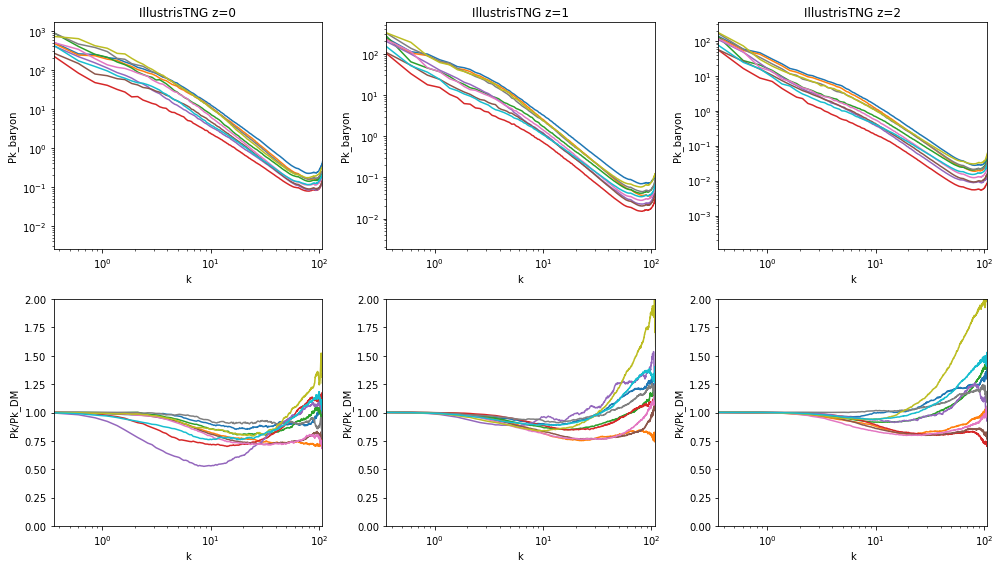

In [8]:
Pk_0 = np.load(home+'Pk/%s_Pk_m_z=0.00.npy'%(isim))
Pk_DM_0 = np.load(home+'Pk/%s_DM_Pk_m_z=0.00.npy'%(isim))
Pk_1 = np.load(home+'Pk/%s_Pk_m_z=1.05.npy'%(isim))
Pk_DM_1 = np.load(home+'Pk/%s_DM_Pk_m_z=1.05.npy'%(isim))
Pk_2 = np.load(home+'Pk/%s_Pk_m_z=2.00.npy'%(isim))
Pk_DM_2 = np.load(home+'Pk/%s_DM_Pk_m_z=2.00.npy'%(isim))

f, axes=subplots(2,3, figsize=(14,8))
ax=axes[0]
for i in range(10):
    ax[0].plot(k, Pk_0[i])
    ax[1].plot(k, Pk_1[i])
    ax[2].plot(k, Pk_2[i])

for j in range(3):
    # ax[j].set_ylim(0, 2)
    ax[j].set_xlim(k[0], k[-20])
    ax[j].set_xscale('log')
    ax[j].set_yscale('log')
    ax[j].set_xlabel('k')
    ax[j].set_ylabel('Pk_baryon')
    ax[j].set_title('%s z=%i'%(isim,j))

ax=axes[1]
for i in range(10):
    ax[0].plot(k, Pk_0[i]/Pk_DM_0[i])
    ax[1].plot(k, Pk_1[i]/Pk_DM_1[i])
    ax[2].plot(k, Pk_2[i]/Pk_DM_2[i])

for j in range(3):
    ax[j].set_ylim(0, 2)
    ax[j].set_xlim(k[0], k[-20])
    ax[j].set_xscale('log')
    ax[j].set_xlabel('k')
    ax[j].set_ylabel('Pk/Pk_DM')
plt.tight_layout()
show()


## Second, take a look at the parameter space (LHC)

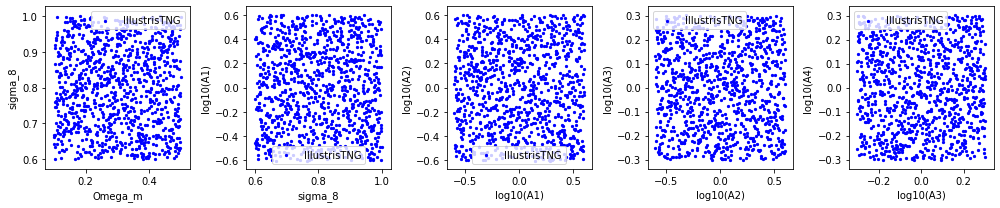

In [9]:
## sort(lhc_TNG.T[0])-sort(lhc_SIMBA.T[0])
### Jia: the 2 parameter files are not sorted the same, but seem to have the same parameters 
### Paco: this is due to LHC, they're not supposed to be the same

labels=['Omega_m', 'sigma_8', 'log10(A1)', 'log10(A2)', 'log10(A3)', 'log10(A4)']
f, ax=subplots(1,5, figsize=(14,3))
for i in range(5):
    ax[i].scatter(lhc_params.T[i], lhc_params.T[i+1], color='b', label=isim,s=5)
    ax[i].set_xlabel(labels[i])
    ax[i].set_ylabel(labels[i+1])   
    ax[i].legend()
plt.tight_layout()
show()

## Step 3, build a Gaussian Process for Pk
## need to find best kernel, noise, kmin

In [10]:
########## test gaussian process by take one out, do this for a few random realizations
#### pick a cosmology close-ish to the center
########## remove one and test
# lhc_test=np.delete(lhc_TNG, idx_min,axis=0)
# Pk_test = np.delete(Pk_0, idx_min,axis=0)
# Pk_DM_test = np.delete(Pk_DM_0, idx_min,axis=0)
# test_distance=(lhc_TNG/mean(lhc_TNG, axis=0)-1)**2
# idx_min = int(where(test_distance==amin(test_distance))[0])
# print (idx_min, lhc_TNG[idx_min])
# print (mean(lhc_TNG, axis=0))

In [11]:
### use the std from all 1000 Pk for now, it is over estimation, should use theory later... e.g. counting modes
## https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html


kmax=10
noise_std =  0.05

kidx=len(k[k<kmax])## cut at kmax
knew = k[:kidx]
r_Pk0=(Pk_0/Pk_DM_0)
Ntest=900

########## remove 100 and use 900 to build, test on 100
lhc_test=lhc_params[:Ntest]

r_Pk = r_Pk0[:900, :kidx]

rtrue= r_Pk0[900:, :kidx]
lhc_true=lhc_params[900:]

print (lhc_test.shape, r_Pk.shape)
print (lhc_true.shape, rtrue.shape)

###### use ready made GP, fast
gaussian_process=buildGP(0, ifolder=isim)

(900, 6) (900, 39)
(100, 6) (100, 39)
/global/homes/j/jialiu/cosmo_dep_feedback/GP/GP_IllustrisTNG_z0.00_kmax10_noise0.050_N900.dump already built


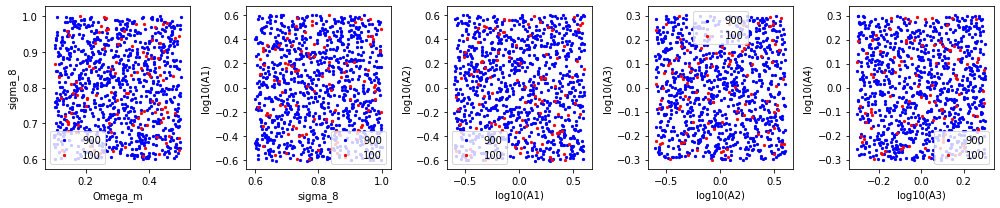

In [12]:
labels=['Omega_m', 'sigma_8', 'log10(A1)', 'log10(A2)', 'log10(A3)', 'log10(A4)']
f, ax=subplots(1,5, figsize=(14,3))
for i in range(5):
    ax[i].scatter(lhc_test.T[i], lhc_test.T[i+1], color='b', label='900',s=5)
    ax[i].scatter(lhc_true.T[i], lhc_true.T[i+1], color='r', label='100',s=5)
    ax[i].set_xlabel(labels[i])
    ax[i].set_ylabel(labels[i+1])  
    ax[i].legend()
plt.tight_layout()
show()

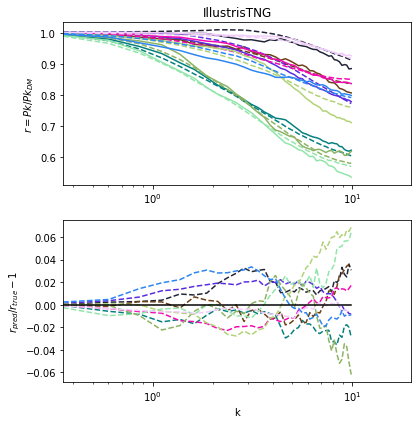

In [13]:
########### may have to build each bin individually
seed(9)

f, ax=subplots(2,1, figsize=(6,6))

for i in range(10):
    
    test_pred = (gaussian_process.predict(lhc_true[i].reshape(-1,1).T)).flatten()
    test_true = rtrue[i].flatten()
    icolor=rand(3)
    ax[0].plot(knew, test_pred, '--',color=icolor)
    ax[0].plot(knew, test_true, '-',color=icolor, label='%s'%(lhc_true[i]))
    ax[1].plot(knew, test_pred/test_true-1, '--',color=icolor)
    

# ax[0].set_ylim(0.5, 1.2)
ax[0].set_xlim(knew[0], knew[-1]*2)
ax[0].set_xscale('log')
ax[0].set_ylabel('$r=Pk/Pk_{DM}$')
ax[0].set_title(isim)
# ax[0].legend()

ax[1].set_xlim(knew[0], knew[-1]*2)
ax[1].set_ylabel('$r_{pred}/r_{true}-1$')
ax[1].plot(knew, zeros(len(knew)),'k-')
ax[1].set_xscale('log')
ax[1].set_xlabel('k')

plt.tight_layout()
show()

(900, 39) (100, 39) (900,) (900,)


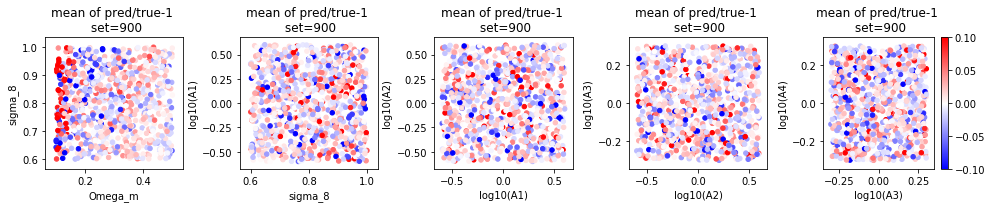

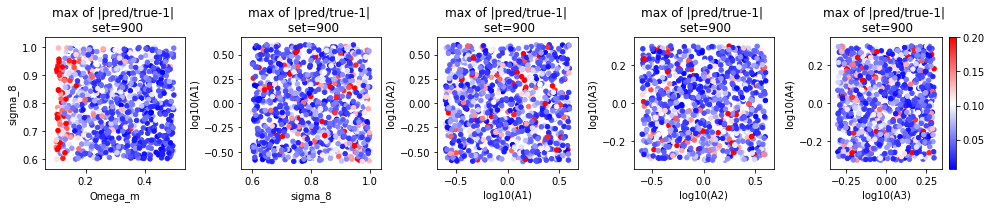

In [14]:
rpred = gaussian_process.predict(lhc_test)

diff_mean = mean(rpred/r_Pk,axis=1)-1
diff_max = amax(abs(rpred/r_Pk-1),axis=1)

print (rpred.shape, rtrue.shape, diff_mean.shape, diff_max.shape)

labels=['Omega_m', 'sigma_8', 'log10(A1)', 'log10(A2)', 'log10(A3)', 'log10(A4)']
f, ax=subplots(1,5, figsize=(14,3))
for i in range(5):
    cb=ax[i].scatter(lhc_test.T[i], lhc_test.T[i+1], c=diff_mean, s=20,
                     cmap='bwr',vmin=-0.1, vmax=0.1)#vmin=amin(diff_mean),  #amax(diff_mean))
    ax[i].set_xlabel(labels[i])
    ax[i].set_ylabel(labels[i+1]) 
    if i==4:
        colorbar(cb,ax=ax[i])
    ax[i].set_title('mean of pred/true-1 \n set=900')
plt.tight_layout()
show()

f, ax=subplots(1,5, figsize=(14,3))
for i in range(5):
    cb=ax[i].scatter(lhc_test.T[i], lhc_test.T[i+1], c=diff_max, s=20,
                     cmap='bwr',vmin=amin(diff_max), vmax=0.2)#amax(diff_max))
    ax[i].set_xlabel(labels[i])
    ax[i].set_ylabel(labels[i+1]) 
    if i==4:
        colorbar(cb,ax=ax[i])
    ax[i].set_title('max of |pred/true-1| \n set=900')
plt.tight_layout()
show()

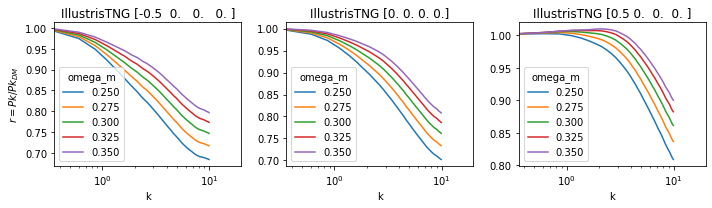

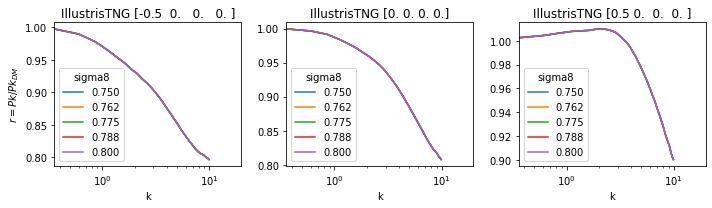

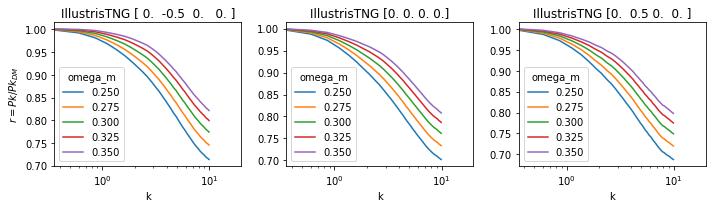

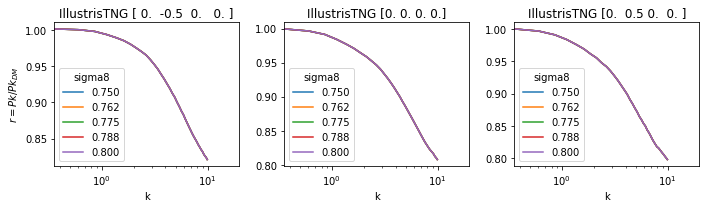

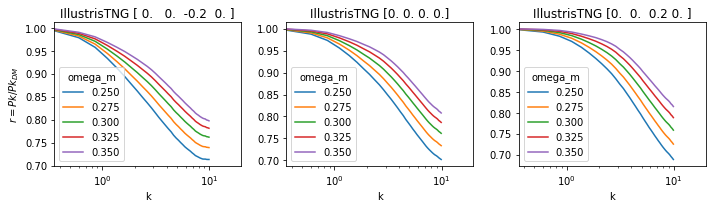

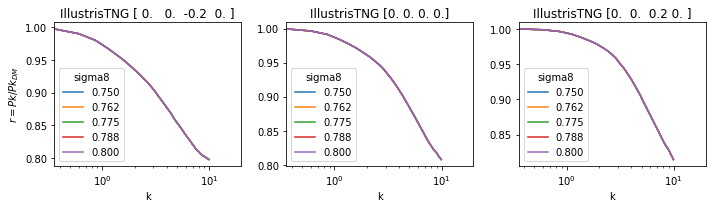

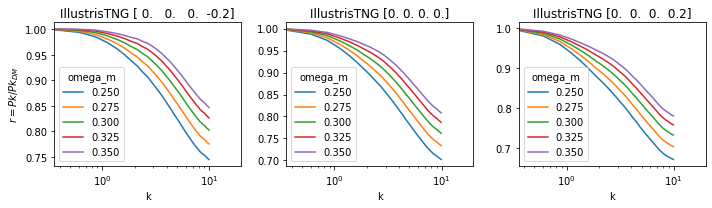

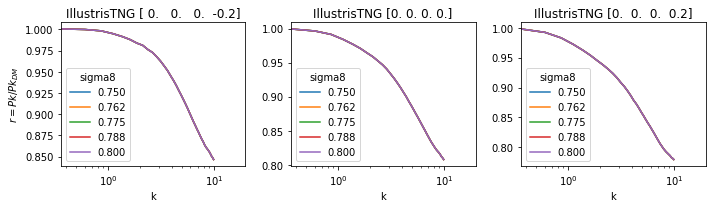

In [15]:
Nbin_cosmo=5
om_arr=linspace(0.25,0.35,Nbin_cosmo)
si8_arr=linspace(0.75, 0.8, Nbin_cosmo)
om=0.3
si8=0.8

Nbin_bary=3
A1, A2, A3, A4 = mean(lhc_params[:,2:],axis=0)
A1_arr = linspace(-0.5, 0.5, Nbin_bary)
A2_arr = linspace(-0.5, 0.5, Nbin_bary)
A3_arr = linspace(-0.2, 0.2, Nbin_bary)
A4_arr = linspace(-0.2, 0.2, Nbin_bary)

for ibary in range(4):
    f,ax=subplots(1, Nbin_bary, figsize=(10,3))
    for i in range(Nbin_bary):
        iparam_bary=zeros(4)
        iparam_bary[ibary]=[A1_arr, A2_arr, A3_arr, A4_arr][ibary][i]
        for jj in range(Nbin_cosmo):
            iom = om_arr[jj]
            iparam=concatenate([[iom, si8], iparam_bary])
            irpred=gaussian_process.predict([iparam,]).flatten()
            ax[i].plot(knew, irpred, label='%.3f'%(iom))
        ax[i].legend(title='omega_m',loc='lower left')
        ax[i].set_title(isim+' %s'%(iparam_bary))
        ax[i].set_xlim(knew[0], knew[-1]*2)
        ax[i].set_xscale('log')  
        ax[i].set_xlabel('k')
    ax[0].set_ylabel('$r=Pk/Pk_{DM}$')
    plt.tight_layout()
    show()

    f,ax=subplots(1, Nbin_bary, figsize=(10,3))
    for i in range(Nbin_bary):
        iparam_bary=zeros(4)
        iparam_bary[ibary]=[A1_arr, A2_arr, A3_arr, A4_arr][ibary][i]
        for kk in range(Nbin_cosmo):
            isi8 = si8_arr[kk]
            iparam=concatenate([[iom, si8], iparam_bary])
            irpred=gaussian_process.predict([iparam,]).flatten()
            ax[i].plot(knew, irpred, label='%.3f'%(isi8))
        ax[i].legend(title='sigma8',loc='lower left')
        ax[i].set_title(isim+' %s'%(iparam_bary))
        ax[i].set_xlim(knew[0], knew[-1]*2)
        ax[i].set_xscale('log')  
        ax[i].set_xlabel('k')
    ax[0].set_ylabel('$r=Pk/Pk_{DM}$')
    plt.tight_layout()
    show()

## seems like sigma8 has little effect, while omega_m has bigger effect (7/11/2022)
#### (1) test if omega_m effect can be accounted for with different age of universe (om=0.25 has longer history, and hence more time for baryons effects, indeed the suppression is the largest)... next, use om=0.35 as baseline, find the corresponding z(age of universe for om 3.5), build an emulator for each redshift, and compare at the same age.
####  (2) may consider build a 7 parameter emulator to take into account of z?

In [16]:
### a function getting t from z, for a given cosmology
### an inverse function getting z from t, for a given cosmology
### https://docs.astropy.org/en/stable/api/astropy.cosmology.z_at_value.html#astropy.cosmology.z_at_value

# Omega_b = 0.049
# h = 0.6711
# ns = 0.9624
# w = -1
# mnu = 0.0 #eV
# Omega_k = 0.0

from astropy.cosmology import FlatLambdaCDM, z_at_value

def z2t (z, om):
    cosmo = FlatLambdaCDM(H0=h*100, Om0=om)
    return cosmo.age(z)

def t2z (t, om):
    cosmo = FlatLambdaCDM(H0=h*100, Om0=om)
    return z_at_value (cosmo.age, t)

In [17]:
om=0.35
t=z2t (0, om)
print (om, t)

# for iom in linspace(0.2, om, 1001)[:-1]:
#     zout = t2z(t, iom)
#     ###### find corredsponding om for z=0.05, 0.1
#     if abs(zout/0.05-1)<0.005 or abs(zout/0.1-1)<0.005:
#         print (iom, zout)

0.35 13.447271368273858 Gyr


In [18]:
### seems like om=0.292 is good for z=0.05, and om=0.2476 is good for z=0.1
for iom in (0.2921, 0.2475):
    print (iom, t2z(t, iom))

0.2921 0.05011651696118677
0.2475 0.10011457302083969


In [19]:
om00 = 0.35
om05 = 0.2921 #z=0.05011651696118677
om10=0.2475 #z=0.10011457302083969

GP0=buildGP (0.00, ifolder=isim)
GP05=buildGP (0.05, ifolder=isim)
GP10=buildGP (0.1, ifolder=isim)

/global/homes/j/jialiu/cosmo_dep_feedback/GP/GP_IllustrisTNG_z0.00_kmax10_noise0.050_N900.dump already built
/global/homes/j/jialiu/cosmo_dep_feedback/GP/GP_IllustrisTNG_z0.05_kmax10_noise0.050_N900.dump already built
/global/homes/j/jialiu/cosmo_dep_feedback/GP/GP_IllustrisTNG_z0.10_kmax10_noise0.050_N900.dump already built


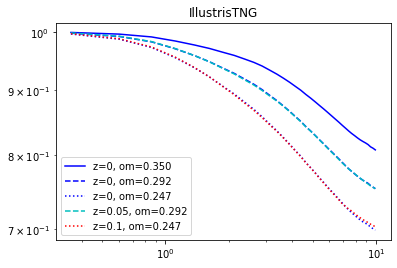

In [20]:
iPk00 = GP0.predict([[om00, 0.8, 0,0,0,0],]).flatten()
iPk05 = GP05.predict([[om05, 0.8, 0,0,0,0],]).flatten()
iPk10 = GP10.predict([[om10, 0.8, 0,0,0,0],]).flatten()

loglog(knew, iPk00, 'b-', label='z=0, om=%.3f'%(om00))
iPk = GP0.predict([[om05, 0.8, 0,0,0,0],]).flatten()
loglog(knew, iPk, 'b--', label='z=0, om=%.3f'%(om05))
iPk = GP0.predict([[om10, 0.8, 0,0,0,0],]).flatten()
loglog(knew, iPk, 'b:', label='z=0, om=%.3f'%(om10))

loglog(knew, iPk05, 'c--',  label='z=0.05, om=%.3f'%(om05))
loglog(knew, iPk10, 'r:', label='z=0.1, om=%.3f'%(om10))

title(isim)
legend()
show()

## seems like om itself is not really causing the difference, next check Pk_b, Pk_c differences

In [21]:
############### check gas and CDM
k=np.load(home+'Pk/IllustrisTNG_k_m_z=0.00.npy')
zarr=[0.00,] # 1.05, 2.00, 0.05, 0.10, 0.15] #

for iz in zarr:
    ifnc=home+'Pk/%s_Pk_c_z=%.2f.npy'%(isim, iz)
    ifng=home+'Pk/%s_Pk_g_z=%.2f.npy'%(isim, iz)
    if os.path.isfile(ifnc) and os.path.isfile(ifng):
        print(ifnc, 'file already exist, continue')
    else:
        print (print (ifnc), 'generated')
        Pkc_arr = array([np.loadtxt(folder_Pk+'%s/LH_%i/Pk_c_z=%.2f.txt'%(isim, i, iz)) for i in range(1000)])
        save(ifnc, Pkc_arr[:,:,1])
        Pkg_arr = array([np.loadtxt(folder_Pk+'%s/LH_%i/Pk_g_z=%.2f.txt'%(isim, i, iz)) for i in range(1000)])
        save(ifng, Pkg_arr[:,:,1])

/global/homes/j/jialiu/cosmo_dep_feedback/Pk/IllustrisTNG_Pk_c_z=0.00.npy file already exist, continue


In [22]:
z=0
iGPg = buildGP (z, ifolder=isim, kmax=10,  noise_std =  0.05, Ntest=900, particles='g')
iGPm = buildGP (z, ifolder=isim, kmax=10,  noise_std =  0.05, Ntest=900, particles='m')
iGPc = buildGP (z, ifolder=isim, kmax=10,  noise_std =  0.05, Ntest=900, particles='c')

/global/homes/j/jialiu/cosmo_dep_feedback/GP/GP_IllustrisTNG_g_z0.00_kmax10_noise0.050_N900.dump already built
/global/homes/j/jialiu/cosmo_dep_feedback/GP/GP_IllustrisTNG_z0.00_kmax10_noise0.050_N900.dump already built
/global/homes/j/jialiu/cosmo_dep_feedback/GP/GP_IllustrisTNG_c_z0.00_kmax10_noise0.050_N900.dump already built


show only Pc


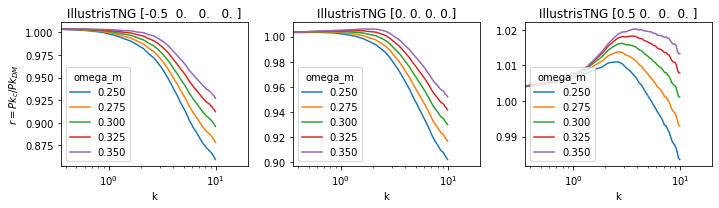

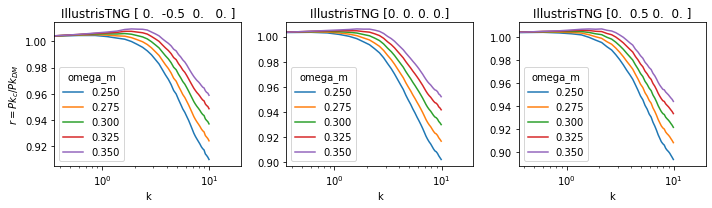

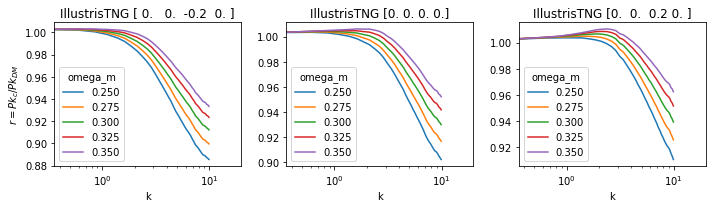

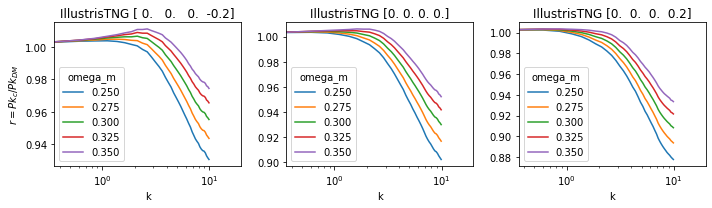

In [23]:
Nbin_cosmo=5
om_arr=linspace(0.25,0.35,Nbin_cosmo)
si8_arr=linspace(0.75, 0.8, Nbin_cosmo)
om=0.3
si8=0.8

Nbin_bary=3
A1, A2, A3, A4 = mean(lhc_params[:,2:],axis=0)
A1_arr = linspace(-0.5, 0.5, Nbin_bary)
A2_arr = linspace(-0.5, 0.5, Nbin_bary)
A3_arr = linspace(-0.2, 0.2, Nbin_bary)
A4_arr = linspace(-0.2, 0.2, Nbin_bary)

print ('show only Pc')
for ibary in range(4):
# for ibary in [0,]:# only look at 1 parameter for now
    f,ax=subplots(1, Nbin_bary, figsize=(10,3))
    for i in range(Nbin_bary):
        iparam_bary=zeros(4)
        iparam_bary[ibary]=[A1_arr, A2_arr, A3_arr, A4_arr][ibary][i]
        for jj in range(Nbin_cosmo):
            iom = om_arr[jj]
            iparam=concatenate([[iom, si8], iparam_bary])
            irpred=iGPc.predict([iparam,]).flatten()
            ########## this is a new line to remove the effect of omega_b/omega_m
            ax[i].plot(knew, irpred, label='%.3f'%(iom))
        ax[i].legend(title='omega_m',loc='lower left')
        ax[i].set_title(isim+' %s'%(iparam_bary))
        ax[i].set_xlim(knew[0], knew[-1]*2)
        ax[i].set_xscale('log')  
        ax[i].set_xlabel('k')
    ax[0].set_ylabel('$r=Pk_c/Pk_{DM}$')
    plt.tight_layout()
    show()

    # f,ax=subplots(1, Nbin_bary, figsize=(10,3))
    # for i in range(Nbin_bary):
    #     iparam_bary=zeros(4)
    #     iparam_bary[ibary]=[A1_arr, A2_arr, A3_arr, A4_arr][ibary][i]
    #     for kk in range(Nbin_cosmo):
    #         isi8 = si8_arr[kk]
    #         iparam=concatenate([[iom, si8], iparam_bary])
    #         irpred=gaussian_process.predict([iparam,]).flatten()
    #         ax[i].plot(knew, irpred, label='%.3f'%(isi8))
    #     ax[i].legend(title='sigma8',loc='lower left')
    #     ax[i].set_title('%s'%(iparam_bary))
    #     ax[i].set_xlim(knew[0], knew[-1]*2)
    #     ax[i].set_xscale('log')  
    #     ax[i].set_xlabel('k')
    # ax[0].set_ylabel('$r=Pk_c/Pk_{DM}$')
    # plt.tight_layout()
    # show()

show only Pg


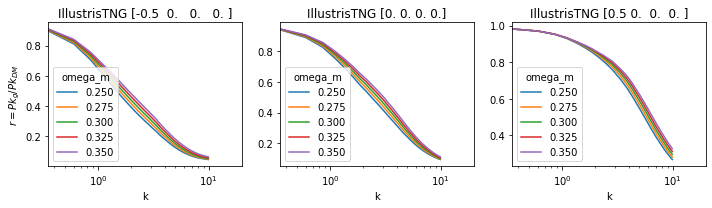

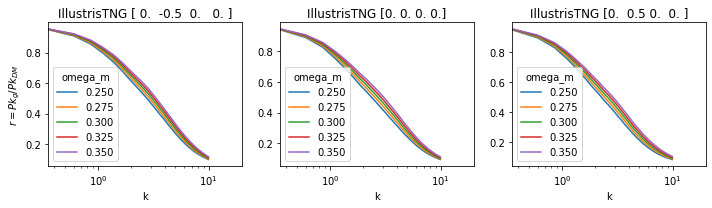

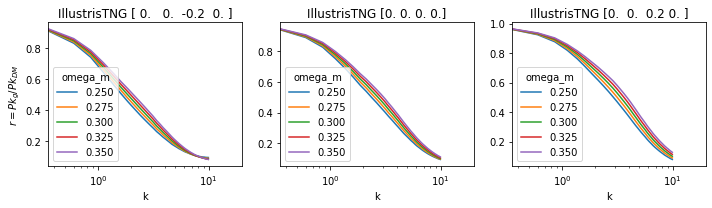

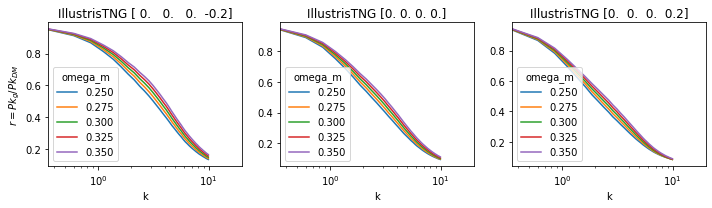

In [24]:
Nbin_cosmo=5
om_arr=linspace(0.25,0.35,Nbin_cosmo)
si8_arr=linspace(0.75, 0.8, Nbin_cosmo)
om=0.3
si8=0.8

Nbin_bary=3
A1, A2, A3, A4 = mean(lhc_params[:,2:],axis=0)
A1_arr = linspace(-0.5, 0.5, Nbin_bary)
A2_arr = linspace(-0.5, 0.5, Nbin_bary)
A3_arr = linspace(-0.2, 0.2, Nbin_bary)
A4_arr = linspace(-0.2, 0.2, Nbin_bary)

print ('show only Pg')

for ibary in range(4):
# for ibary in [0,]:# only look at 1 parameter for now
    f,ax=subplots(1, Nbin_bary, figsize=(10,3))
    for i in range(Nbin_bary):
        iparam_bary=zeros(4)
        iparam_bary[ibary]=[A1_arr, A2_arr, A3_arr, A4_arr][ibary][i]
        for jj in range(Nbin_cosmo):
            iom = om_arr[jj]
            iparam=concatenate([[iom, si8], iparam_bary])
            irpred=iGPg.predict([iparam,]).flatten()
            ########## this is a new line to remove the effect of omega_b/omega_m
            ax[i].plot(knew, irpred, label='%.3f'%(iom))
        ax[i].legend(title='omega_m',loc='lower left')
        ax[i].set_title(isim+' %s'%(iparam_bary))
        ax[i].set_xlim(knew[0], knew[-1]*2)
        ax[i].set_xscale('log')  
        ax[i].set_xlabel('k')
    ax[0].set_ylabel('$r=Pk_g/Pk_{DM}$')
    plt.tight_layout()
    show()

    # f,ax=subplots(1, Nbin_bary, figsize=(10,3))
    # for i in range(Nbin_bary):
    #     iparam_bary=zeros(4)
    #     iparam_bary[ibary]=[A1_arr, A2_arr, A3_arr, A4_arr][ibary][i]
    #     for kk in range(Nbin_cosmo):
    #         isi8 = si8_arr[kk]
    #         iparam=concatenate([[iom, si8], iparam_bary])
    #         irpred=gaussian_process.predict([iparam,]).flatten()
    #         ax[i].plot(knew, irpred, label='%.3f'%(isi8))
    #     ax[i].legend(title='sigma8',loc='lower left')
    #     ax[i].set_title(isim+' %s'%(iparam_bary))
    #     ax[i].set_xlim(knew[0], knew[-1]*2)
    #     ax[i].set_xscale('log')  
    #     ax[i].set_xlabel('k')
    # ax[0].set_ylabel('$r=Pk_g/Pk_{DM}$')
    # plt.tight_layout()
    # show()